In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import math
from math import exp
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

import joblib

In [2]:
data = pd.read_excel("/content/dataset.xlsx")
data.head()

,ID,Reaction,%ee,ddG_exp_value,d.BL1,d.BL2,d.BL3,d.BL4,d.D1,d.D2,...,CPA_B5(Bmax),CPA_L,d(BE),Traceless_QM,A.Nitroso,A.Indole,A.CPA,V.Nitroso,V.Indole,V.CPA
0,R0004,aa1,64,0.909808,0.78279,0.01504,0.00500,0.57663,-176.61232,23.52332,...,3.27,8.5,0.005408,-5.3209,168.272,211.301,538.661,137.47,168.718,466.146
1,R0005,aa2,86,1.552014,0.81500,0.04768,0.08226,-0.19524,-172.79376,23.72889,...,7.04,8.2,0.006525,-8.1108,168.272,211.301,791.973,137.47,168.718,694.528
2,R0006,aa3,87,1.599696,-0.05567,0.01224,0.06187,-1.57136,-177.04393,0.61468,...,5.69,6.6,0.009486,-7.5545,168.272,211.301,566.192,137.47,168.718,503.718
3,R0007,aa4,96,2.335092,0.76173,0.04037,0.06304,-1.52496,-171.20815,2.32143,...,5.69,6.5,0.007321,-10.4128,168.272,211.301,654.560,137.47,168.718,588.947
4,R0008,aa5,96,2.335092,1.65383,0.03142,0.00520,0.00633,-178.71876,8.31042,...,5.71,8.5,0.006261,-10.4281,168.272,211.301,655.490,137.47,168.718,588.843


In [3]:
data1 = data.drop(['ID', 'Reaction','%ee'], axis=1)
data2 = data1.dropna()
print("Number of rows:",len(data2))
print("Number of columns:",len(data2.columns))

Number of rows: 41
Number of columns: 27


In [4]:
cor = data2.corr()

In [5]:
target_cor = cor['ddG_exp_value']
less_correlated_features = target_cor[abs(target_cor)<0.15].index
data2 = data2.drop(less_correlated_features, axis=1)

In [6]:
less_correlated_features

Index(['DM rc_minor', 'A.Indole', 'A.CPA', 'V.Indole'], dtype='object')

In [7]:
X = data2.drop("ddG_exp_value", axis=1)
y = data2[['ddG_exp_value']]

In [8]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

In [9]:
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [10]:
X_norm = pd.DataFrame(X_norm, columns=X.columns)
X_norm.head()

,d.BL1,d.BL2,d.BL3,d.BL4,d.D1,d.D2,N1 rc_major,N1 rc_minor,I1 rc_major,I1 rc_minor,...,P rc_major,P rc_minor,CPA_B1(Bmin),CPA_B5(Bmax),CPA_L,d(BE),Traceless_QM,A.Nitroso,V.Nitroso,V.CPA
0,-0.320906,-1.400706,-1.290742,1.794011,-0.834568,1.401557,-2.999337,-0.937019,-1.011412e-01,-1.528122,...,-2.975635,-2.902272,-0.381026,-3.107771,1.548997,-0.294427,1.674293,-0.518863,-0.510977,-2.611899
1,-0.284067,0.515334,0.983639,0.743141,0.612325,1.421681,-1.225034,1.245809,-1.011412e-01,-0.046964,...,1.004488,0.957757,1.441102,1.947140,1.233817,0.364866,0.459359,-0.518863,-0.510977,2.123089
2,-1.279874,-1.565072,0.383398,-1.130390,-0.998109,-0.840972,0.549268,-0.937019,1.011412e-01,-0.195079,...,-2.152556,-2.184462,-0.461414,0.137026,-0.447146,2.112554,0.701614,-0.518863,-0.510977,-1.832928
3,-0.344993,0.086221,0.417840,-1.067218,1.213129,-0.673898,0.822238,-0.282170,-1.415977e+00,-0.195079,...,-0.495035,-0.469923,-0.434618,0.137026,-0.552207,0.834694,-0.543106,-0.518863,-0.510977,-0.065896
4,0.675324,-0.439164,-1.284855,1.017571,-1.632720,-0.087635,1.368177,0.590961,5.614464e-15,-2.268701,...,-0.519488,-0.503408,-0.381026,0.163842,1.548997,0.209044,-0.549769,-0.518863,-0.510977,-0.068052


In [11]:
param_grid = {
    'n_estimators': [50, 200, 250, 300],
    'max_depth': [3, 5, 10],
    'criterion': ['friedman_mse'],
    'max_features': ['sqrt'],
    'random_state': [95]
}

#Scoring function
scorer = make_scorer(mean_squared_error, greater_is_better=False)


X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=45)

rfr = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring=scorer, cv=LeaveOneOut(), n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)

# Results
print("Best parameters found by GridSearchCV:", best_params)
print("Best CV RMSE:", best_score)

Best parameters found by GridSearchCV: {'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50, 'random_state': 95}
Best CV RMSE: 0.6362144226142458


In [12]:
best_rfr = RandomForestRegressor(**best_params)

In [13]:
best_rfr.fit(X_train, y_train)

# Predictions on train set
y_train_pred = best_rfr.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Predictions on test set
y_test_pred = best_rfr.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print("Training set RMSE: ", train_rmse)
print("Training set R2 Score: ", train_r2)
print("Test RMSE: ", test_rmse)
print("Test R2 Score: ", test_r2)

Training set RMSE:  0.27566598250494573
Training set R2 Score:  0.9205036586058706
Test RMSE:  0.3210796383242386
Test R2 Score:  0.8759015029373294


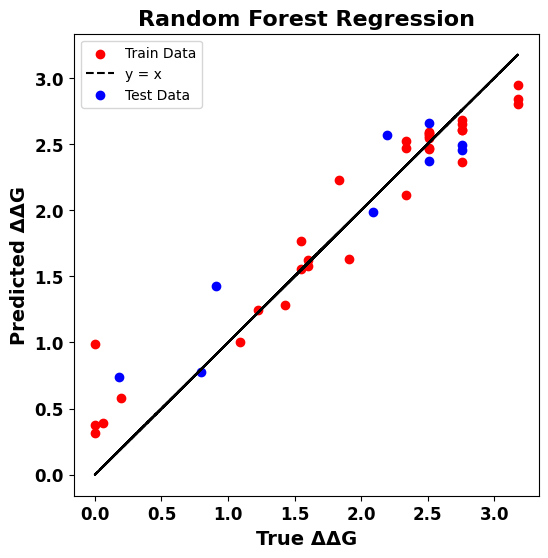

In [14]:
xPlot = y_train
yPlot = y_train_pred
x1Plot = y_test
y1Plot = y_test_pred

fig = plt.figure(figsize=(6, 6))
plt.scatter(xPlot, yPlot, color='red', label='Train Data')
plt.plot(xPlot, xPlot, linestyle='--', color='black', label='y = x')
plt.scatter(x1Plot, y1Plot, color='blue', label='Test Data')
plt.xlabel('True ΔΔG', fontweight='bold', fontsize=14)
plt.ylabel('Predicted ΔΔG', fontweight='bold', fontsize=14)
plt.title('Random Forest Regression', fontweight='bold', fontsize=16)
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")

plt.legend()
plt.show()

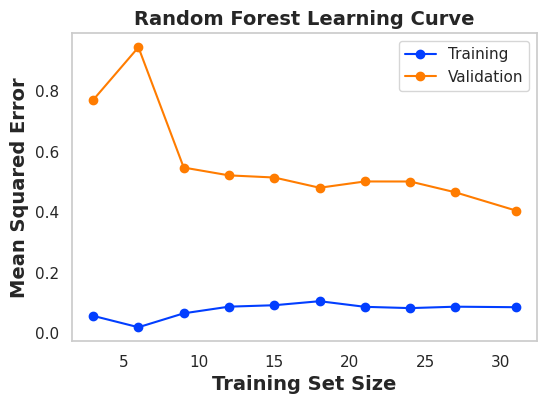

In [15]:
train_sizes_lc, train_scores_lc, valid_scores_lc = learning_curve(best_rfr, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=LeaveOneOut(), scoring='neg_mean_squared_error')
train_scores_mean_lc = -np.mean(train_scores_lc, axis=1)
valid_scores_mean_lc = -np.mean(valid_scores_lc, axis=1)

sns.set(style="whitegrid")
sns.set_palette("bright")

plt.figure(figsize=(6, 4))
plt.plot(train_sizes_lc, train_scores_mean_lc, label='Training', marker='o')
plt.plot(train_sizes_lc, valid_scores_mean_lc, label='Validation', marker='o')
plt.title('Random Forest Learning Curve', fontweight='bold', fontsize=14)
plt.xlabel('Training Set Size', fontweight='bold', fontsize=14)
plt.ylabel('Mean Squared Error', fontweight='bold', fontsize=14)
plt.gca().grid(False)
plt.legend()
plt.show()

In [16]:
test_index = X_test.index
true_ee = data.loc[test_index,'%ee']

pred_ee = []
m = len(y_test_pred)
for i in range(0,m):
  ee = -1*100*(1-exp(y_test_pred[i]/0.6))/(1+exp(y_test_pred[i]/0.6))
  pred_ee.append(ee)

In [17]:
train_index = X_train.index
train_true_ee = data.loc[train_index,'%ee']

train_pred_ee = []
m = len(y_train_pred)
for i in range(0,m):
  ee = -1*100*(1-exp(y_train_pred[i]/0.6))/(1+exp(y_train_pred[i]/0.6))
  train_pred_ee.append(ee)

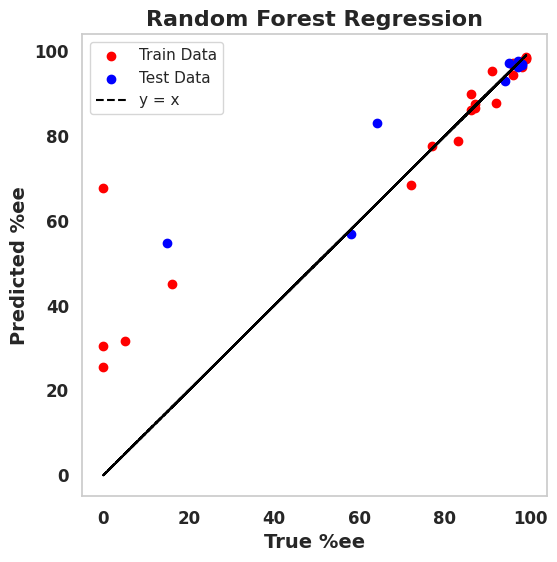

In [18]:
xPlot_ee = train_true_ee
yPlot_ee = train_pred_ee
x1Plot_ee = true_ee
y1Plot_ee = pred_ee

fig = plt.figure(figsize=(6, 6))
plt.scatter(xPlot_ee, yPlot_ee, color='red', label='Train Data')  # train
plt.scatter(x1Plot_ee, y1Plot_ee, color='blue', label='Test Data') #test
plt.plot(xPlot_ee, xPlot_ee, linestyle='--', color='black', label='y = x')
plt.xlabel('True %ee', fontweight='bold', fontsize=14)
plt.ylabel('Predicted %ee', fontweight='bold', fontsize=14)
plt.title('Random Forest Regression', fontweight='bold', fontsize=16)
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.gca().grid(False)
plt.legend()
plt.show()

In [19]:
rmse_ee_train = np.sqrt(mean_squared_error(train_true_ee, train_pred_ee))
r2_ee_train = r2_score(train_true_ee, train_pred_ee)

print("RMSE in %ee prediction (train_set): ", rmse_ee_train)
print("R2 Score in %ee prediction (train_set):", r2_ee_train)

RMSE in %ee prediction (train_set):  15.637927279352901
R2 Score in %ee prediction (train_set): 0.7758654801220557


In [20]:
rmse_ee = np.sqrt(mean_squared_error(true_ee, pred_ee))
r2_ee = r2_score(true_ee, pred_ee)

print("RMSE in %ee prediction (testset): ", rmse_ee)
print("R2 Score in %ee prediction (testset):", r2_ee)

RMSE in %ee prediction (testset):  14.750687553862992
R2 Score in %ee prediction (testset): 0.703755035160244


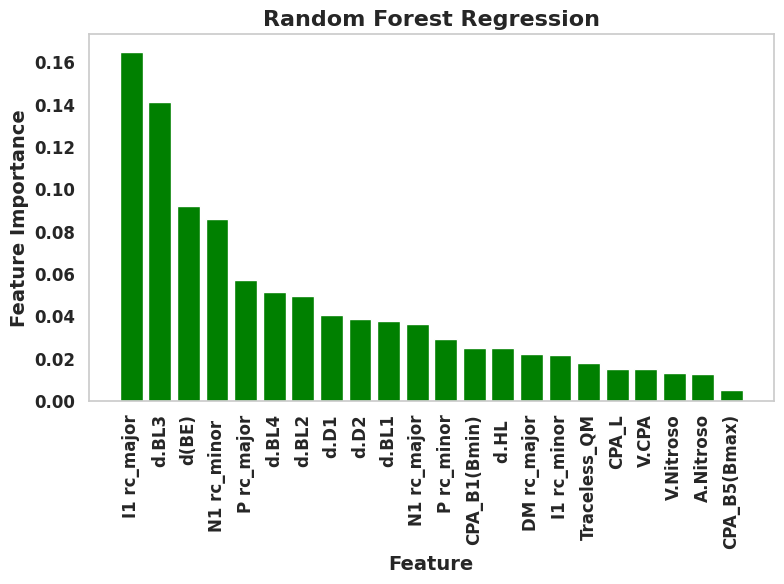

In [21]:
importances = best_rfr.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances = importances[sorted_indices]

plt.figure(figsize=(8,6))
plt.bar(range(len(sorted_feature_names)), sorted_importances, align='center',color='green')
plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=90, fontsize=12, fontweight='bold')
plt.xlabel('Feature', fontweight='bold', fontsize=14)
plt.ylabel('Feature Importance', fontweight='bold', fontsize=14)
plt.title('Random Forest Regression', fontweight='bold', fontsize=16)
plt.yticks(fontweight='bold', fontsize=12)
plt.gca().grid(False)
plt.tight_layout()
plt.show()

In [22]:
scaler = joblib.load('scaler.joblib')

**Ext.Test Set**

In [23]:
ext_test = pd.read_excel("/content/ext_testset.xlsx")
ext_test = ext_test.drop(['ID'], axis=1)

In [24]:
ext_test = ext_test.drop([col for col in less_correlated_features], axis=1)

In [25]:
ext_X = ext_test.dropna()

In [26]:
ext_X_norm = scaler.transform(ext_X)

In [27]:
ext_y_pred = best_rfr.predict(ext_X_norm)

In [28]:
ext_y_pred

array([1.06232922, 1.63463006])

In [29]:
n=len(ext_y_pred)
for i in range(0,n):
  ee= -1*100*(1-exp(ext_y_pred[i]/0.6))/(1+exp(ext_y_pred[i]/0.6))
  print("Predicted %ee (external testset-2):",ee)

Predicted %ee (external testset-2): 70.9051785972617
Predicted %ee (external testset-2): 87.69004291867249
